In [1]:
import datetime
from matplotlib import pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import plotly.io as pio
from plotly.offline import plot
import pandas as pd
import numpy as np

### Define Some Useful Functions for Feature Engineering

In [ ]:
# financial indicator functions
# note that these are indented to work with ONE key value
# ex. ONLY DATES means that we must group by stock ticker
# note: TICKERS will not make sense for these functions as keys

def check_series_numeric(column) -> bool:
    not_numeric = column.apply(pd.to_numeric, errors = 'coerce').isna().all()
    # if the data is not numeric, the test failed 
    return not not_numeric

def calculate_sma(column, period = 10):
    if not check_series_numeric(column):
        return column
    sma = column.rolling(period).mean()
    return pd.Series(sma, index= column.index, name = 'SMA')

def calculate_ema(column, period = 10):
    if not check_series_numeric(column):
        return column
    ema = column.ewm(span = period, min_periods = period - 1).mean()
    return pd.Series(ema, index = column.index, name = 'EMA')

def calculate_rsi_helper(column, period = 14, use_exponential = False):
    if not check_series_numeric(column):
        return column 

    column = column.astype(float)
    # find differences in prices
    differences = column.diff() 

    # clip, but center off of zero value
    gain = differences.clip(lower = 0.01)
    loss = differences.clip(upper = -0.01)

    avg_gain = gain.mean()
    avg_loss = loss.mean()

    if use_exponential:
        # get the exponential weighted mean of the very last element in this current rolling window
        avg_gain = gain.ewm(span = period, min_periods = period - 1).mean().iloc[-1]
        avg_loss = loss.ewm(span = period, min_periods = period - 1).mean().iloc[-1]

    RS = avg_gain / avg_loss 
    RSI = 100 - 100 / (1 - RS)

    return RSI

'''
    let RS = average gain / average loss   
    RSI = 100 - 100 / (1 - RS)

    some things to look out for: 
        - using exponential weighted means on the average
            gains and losses made the RSI value much more
            sensitive and fluctuating more based on price
            changes
        - using simple averages made the RSI value more 
            smoothed out

    keyword argument options:
        - period: type int
        - use_exponential: type bool

'''
def calculate_rsi(column, period, use_exponential):
    rsi = column.rolling(14).apply(lambda x: calculate_rsi_helper(x, period=period, use_exponential=use_exponential)).astype(float)
    return pd.Series(rsi, index = column.index, name = 'RSI')

'''
    MACD (moving average convergence/ divergence) shows the relationship
    between two exponential moving averages and comparing this to the 
    9-day EMA line 

    MACD = 12-period EMA - 26-period EMA 
    Signal = 9-period EMA - 26-period EMA
'''
def calculate_macd(column, long_period = 26, short_period = 12, signal_period = 9) -> tuple[object, object]:
    if not check_series_numeric(column):
        return column 
    
    # Calculate the short and long EMAs
    ewm_short = column.ewm(span=short_period, min_periods=short_period-1).mean()
    ewm_long = column.ewm(span=long_period, min_periods=long_period-1).mean()

    # Calculate MACD line
    macd = (ewm_short - ewm_long).astype(float)

    # Calculate the Signal line (EMA of MACD)
    ewm_signal = macd.ewm(span=signal_period, min_periods=signal_period-1).mean()
    signal = ewm_signal.astype(float)

    # Return both MACD and Signal as pandas Series
    macd = pd.Series(macd, index=column.index, name='MACD')
    signal = pd.Series(signal, index=column.index, name='MACD-SIGNAL')

    return macd, signal

"""
    Calculate the average stock price between 30 and 45 days after the present day.
    Expects that data is given in sorted order by date.

    - data: pd.DataFrame with stock data indexed by date.
    - column_name: str, the column name containing the stock prices.
    This returns the average stock price between 30 and 45 days after the present day.
"""
def calculate_future_average_stock_price(column, start_period=10, end_period=30) -> pd.Series:
    """
        Calculate the average stock price between +start_period and +end_period days from the present day.
    
        :param column: pd.Series, the stock prices.
        :param start_period: int, the start period.
        :param end_period: int, the end period.

        For 

    """
    MINTHRESH_PROP = 0.5

    future_average_prices = []

    for i in range(len(column)):
        cur_date = column.index[i]

        future_dates = [cur_date + datetime.timedelta(days=j) for j in range(start_period, end_period + 1)]
        valid_future_dates = [date for date in future_dates if date in column.index]

        future_prices = column.loc[valid_future_dates]
        # weekends are not included in the future prices, but that's okay as long as we ensure that
        # all weekend days missing are accounted for

        # 0 = Monday, ... 6 = Saturday, 7 = Sunday
        day_of_week_future_dates = [int(date.weekday()) for date in future_dates]
        num_weekdays = sum([int(day_num <= 4) for day_num in day_of_week_future_dates])
        # print("expected weekdays:", num_weekdays, "weekday in loc", len(future_prices))

        num_future_prices = len(future_prices)

        # add price to the future price average list if there are sufficient or exactly the same
        # number of samples as expected for stock prices in the future
        if num_future_prices == num_weekdays or num_future_prices > \
            int((end_period - start_period + 1) * MINTHRESH_PROP):
            future_average_prices.append(future_prices.mean())
        else:
            future_average_prices.append(None)
            
    future_average_prices = pd.Series(future_average_prices, index=column.index, name=f"FutureAverage{start_period}-{end_period}")

    return future_average_prices

### Some Useful Utility Functions Used Throughout the Project

In [3]:
""" 
    Data cleaning and feature engineering the tickers dataframe:
        - I only ned to know Adj Close and Volume numbers for relevant metrics per each stock
        - The stocks of interest are:
            - Stock that I am predicting for trading
            - Probably some other related stocks (2-6 of them)
            - Global market conditions indicators
"""
def extract_tickers_ticker(
        tickers_df: pd.DataFrame, tickers: list[str], 
        start: datetime.datetime, end: datetime.datetime) -> pd.DataFrame:

    res_df = tickers_df[tickers]
    cols_to_keep = set(["Adj Close", "Volume"])
    remapped_columns = [f"{outer}:{inner}" for outer, inner in res_df.columns]
    apple_cols_to_keep = ["Ticker:Price"] + \
        [f"{outer}:{inner}" for outer, inner in res_df.columns if inner in cols_to_keep]
    res_df.columns = remapped_columns
    res_df = res_df[apple_cols_to_keep]
    res_df = res_df.iloc[1:]
    res_df["Ticker:Price"] = pd.to_datetime(res_df["Ticker:Price"])
    res_df = res_df[(res_df["Ticker:Price"] >= start) & (res_df["Ticker:Price"] <= end)]
    res_df = res_df.set_index("Ticker:Price").rename_axis("Date")

    return res_df

def parse_technical_indicators(
        tickers_df: pd.DataFrame, tickers: list[str], ticker: str,
        start: datetime.datetime, end: datetime.datetime,
        short_period: int = 15, long_period: int = 30) -> pd.DataFrame:
    
    res_df = extract_tickers_ticker(tickers_df, tickers, start, end)

    # get the Y value: future average stock price
    res_df["future_avg_price"] = calculate_future_average_stock_price(res_df[f"{ticker}:Adj Close"])
    cols = res_df.columns
    for colname in cols:
        if "Volume" in colname:
            # get the ewn of volumes
            res_df[colname + "_ewm_short"] = res_df[colname].ewm(span=short_period, adjust=False).mean()
            res_df[colname + "_ewm_long"] = res_df[colname].ewm(span=long_period, adjust=False).mean()
        elif "Adj Close" in colname:
            # get RSI & MACD signal difference otherwise
            res_df[colname + "_rsi"] = calculate_rsi(res_df[colname], period=14, use_exponential=True)
            macd, signal = calculate_macd(res_df[colname])
            res_df[colname + "_macd"] = macd
            res_df[colname + "_signal"] = signal

    return res_df

def extract_congressional_trades_ticker(congressional_df: pd.DataFrame, tickers: list[str]) -> pd.DataFrame:

    res_df = filter_congressional_trades_ticker(congressional_df, tickers)
    res_df["disclosure_date"] = pd.to_datetime(res_df["disclosure_date"])

    res_df["type"] = res_df["type"].str.lower()
    res_df = res_df[~res_df["type"].str.contains("exchange")]

    res_df["type"] = res_df["type"].str.contains("purchase", na=False) # True if purchase
    smmap = {True: "purchase", False: "sale"}
    res_df["type"] = res_df["type"].map(smmap)

    res_df.set_index("disclosure_date", inplace=True)

    res_df = res_df[["ticker", "type", "amount"]]

    res_df["count"] = 1
    res_df = res_df.pivot_table(
        columns="type", 
        values="count", 
        aggfunc="sum", 
        index=["disclosure_date", "ticker"],
        ).fillna(0)

    res_df = res_df.rename_axis(columns=None).reset_index()
    res_df = res_df.set_index("disclosure_date")

    return res_df

def filter_congressional_trades_ticker(congressional_df: pd.DataFrame, tickers: list[str]) -> pd.DataFrame:
    filtered_df = congressional_df[congressional_df["ticker"].notna()]
    filtered_df = filtered_df[filtered_df["ticker"].str.contains('|'.join(tickers))]
    filtered_df.drop(["Unnamed: 0"], inplace=True, axis=1)
    return filtered_df

### Some Useful Functions for Data Visualization

In [4]:
# plotting the technical indicators of volume, RSI, and MACD_diff
def plot_technical_indicators(
        stock_data_df: pd.DataFrame, start: datetime.datetime, end: datetime.datetime,
        ticker_name: str) -> None:
    ticker_name = ticker_name.upper()
    plot_df = stock_data_df[(stock_data_df.index >= start) & (stock_data_df.index <= end)]

    trace_price = go.Scatter(x=plot_df.index, y=plot_df[f"{ticker_name}:Adj Close"], mode='lines', name='Price')
    trace_rsi = go.Scatter(x=plot_df.index, y=plot_df[f"{ticker_name}:Adj Close_rsi"], mode='lines', name='RSI')
    trace_overbought = go.Scatter(x=plot_df.index, y=[70] * len(plot_df), mode='lines', name='Overbought', line=dict(color='red', dash='dash'))
    trace_oversold = go.Scatter(x=plot_df.index, y=[30] * len(plot_df), mode='lines', name='Oversold', line=dict(color='green', dash='dash'))
    trace_macd = go.Scatter(x=plot_df.index, y=plot_df[f"{ticker_name}:Adj Close_macd"], mode='lines', name='MACD')
    trace_signal = go.Scatter(x=plot_df.index, y=plot_df[f"{ticker_name}:Adj Close_signal"], mode='lines', name='Signal')

    fig = make_subplots(rows=3, cols=1, shared_xaxes=True, vertical_spacing=0.02,
                        subplot_titles=["Stock Price", "RSI", "MACD"])

    fig.add_trace(trace_price, row=1, col=1)
    fig.add_trace(trace_rsi, row=2, col=1)
    fig.add_trace(trace_overbought, row=2, col=1)
    fig.add_trace(trace_oversold, row=2, col=1)
    fig.add_trace(trace_macd, row=3, col=1)
    fig.add_trace(trace_signal, row=3, col=1)

    fig.update_layout(
        title_text=f"${ticker_name} Technical Indicators",
        title_font=dict(color="white", size=20),
        
        # Dark background settings
        plot_bgcolor="#1c1c1c",  # Dark background for the plot area
        paper_bgcolor="#121212",  # Dark background for the surrounding area
        
        # Axes and gridline settings
        xaxis=dict(
            showgrid=True,
            gridcolor="#444444",  # Gridline color
            tickangle=45,
            tickmode="array",
            tickfont=dict(color="white")
        ),
        yaxis=dict(
            showgrid=True,
            gridcolor="#444444",  # Gridline color
            tickfont=dict(color="white"),
        ),
        
        # Additional customizations for ticks, labels, etc.
        font=dict(color="white"),  # Set general text color to white
        height=800, width=800
    )
    
    # pip install -U kaledio
    pio.renderers.default = "png"
    fig.show()

# for macd, if the macd line crosses the signal line, that is a bullish crossover
# if the macd line crosses below the signal line, that is a bearish crossover

def plot_congressional_trades_bar(congressional_df: pd.DataFrame, tickers: list[str]) -> None:
    """ 
        Given the raw congressional trading dataframe, plot the frequency of trades
        for either a sale or a purchase of the stock. This function will naively assume
        that any type of purchase is a "buy", whereas any type of sell is a "sell",
        despite the fact that there are more subleties to this where one can either
        partially buy or sell a stock at varying exchange amounts.
    """

    ## some data exploration on the apple congressional data
    filtered_df = filter_congressional_trades_ticker(congressional_df, tickers)

    summarized_cong_df = filtered_df.groupby(["amount", "type"]).size().reset_index()
    summarized_cong_df.columns = ["amount", "type", "count"]
    unique_amounts = summarized_cong_df["amount"].unique()
    unique_amounts_sorted = sorted(unique_amounts, key=lambda x: \
        int([str_x for str_x in x.replace('$', '').replace(',', '').split(' ') if str_x.isnumeric()][-1]))

    summarized_cong_df["type"] = summarized_cong_df["type"].str.lower()
    # i am not considering "exchange" as a valid trade option
    summarized_cong_df = summarized_cong_df[~summarized_cong_df["type"].str.contains("exchange")]
    summarized_cong_df["type"] = summarized_cong_df["type"].str.contains("purchase", na=False) # True if purchase
    smmap = {True: "purchase", False: "sale"}
    summarized_cong_df["type"] = summarized_cong_df["type"].map(smmap)

    purchase_types = summarized_cong_df.groupby(["amount", "type"]).sum().reset_index()

    def _extract_purchase_sell(X: pd.DataFrame):
        purchase_amt = X[X["type"].str.contains("purchase")]["count"].sum()
        sell_amt = X[X["type"].str.contains("sale")]["count"].sum()
        return pd.Series([purchase_amt, sell_amt], index=["purchase", "sale"])

    DARKGRAY = "#1c1c1c"
    GREEN = "#46cb46"
    RED = "#e73f3f"

    purchase_types = purchase_types.groupby("amount").apply(_extract_purchase_sell)
    purchase_types = purchase_types.reindex(unique_amounts_sorted)

    fig, ax = plt.subplots()
    bottom = np.zeros(len(unique_amounts))

    for amt_type in ["sale", "purchase"]:
        ax.bar(purchase_types.index, purchase_types[amt_type], label=amt_type, color = GREEN if amt_type == "purchase" else RED, bottom=bottom)
        bottom += purchase_types[amt_type].to_numpy()

    # Create the plot
    fig.patch.set_facecolor(DARKGRAY)
    ax.set_facecolor(DARKGRAY)

    # Add gridlines and customize ticks
    ax.grid(axis="y", linestyle="--", alpha=0.6, color="gray")
    ax.tick_params(axis="x", rotation=80, colors="white")
    ax.tick_params(axis="y", colors="white")


    # Set title with a line break
    title_text = f"Frequency of Congressional\nTrade Amount Categories For: \n${', '.join(tickers)}"
    ax.set_title(title_text, fontsize=16, weight='bold', color="white", pad=20)

    # Add labels for x and y axes
    ax.set_xlabel("Trade Amount Categories", fontsize=12, color="white")
    ax.set_ylabel("Frequency", fontsize=12, color="white", labelpad=10)

    # Set axis lines (spines) to white
    ax.spines['bottom'].set_color('white')  # X-axis line
    ax.spines['left'].set_color('white')    # Y-axis line
    ax.spines['top'].set_color('white')     # Hide top line
    ax.spines['right'].set_color('white')   # Hide right line

    # Add a legend
    plt.legend(title="Trade Type")

    # Adjust the layout to prevent label clipping
    plt.tight_layout()

    # Show the plot
    plt.show()

def plot_congressional_trades_timeseries(
        training_ticker_congressional_df: pd.DataFrame, start: datetime.datetime, end: datetime.datetime,
        ticker: str, title: str = 'Future Avg Price and Transaction Volume Over Time', barwidth: int = 15) -> None:

    sub_df = training_ticker_congressional_df[(training_ticker_congressional_df.index >= start) & \
                                              (training_ticker_congressional_df.index <= end)]

    # Visualize the merged dataframe with congressional and time series insights
    fig, ax1 = plt.subplots(figsize=(14,7))

    ax1.plot(sub_df.index, sub_df['future_avg_price'], label='Future Avg Price', color='blue', linewidth=2)
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Future Avg Price', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.set_title(title)

    # Create a secondary y-axis for transaction counts
    ax2 = ax1.twinx()

    # Adjust bar width and offsets
    width = np.timedelta64(10, 'D')  # Offset width for separation (10 days)

    # Plot Purchases
    ax2.bar(
        sub_df.index,  # Shift purchases bars to the left
        sub_df[f"purchase_{ticker}"],
        color='green',
        alpha=0.6,
        width=barwidth,  # Reduce bar width
        label='Purchases'
    )

    # Plot Sells
    ax2.bar(
        sub_df.index,  # Shift sells bars to the right
        sub_df[f"sale_{ticker}"],
        color='red',
        alpha=0.6,
        width=barwidth,  # Reduce bar width
        label='Sells'
    )

    # # Set y-axis label for transactions
    ax2.set_ylabel('Transaction Volume', color='gray')
    ax2.tick_params(axis='y', labelcolor='gray')

    # # Add legends for both plots
    fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))
    plt.tight_layout()
    plt.show()

### Prepare AAPL Tickers & Technical Indicators

In [5]:
if "tickers_df" not in dir():
    tickers_df = pd.read_csv("./data/stock_ticker_data.csv", header=[0,1])

prediction_ticker = ["Ticker", "AAPL"]
relevant_tickers = ["MSFT", "AMZN", "GOOGL", "META", "NVDA"]
global_market_tickers = ["GC=F", "CL=F", "^GSPC", "^VIX", "DX-Y.NYB", "HG=F"]

training_df = parse_technical_indicators(tickers_df, prediction_ticker + relevant_tickers + global_market_tickers, "AAPL",
                       datetime.datetime(2014, 1, 1), datetime.datetime(2023, 1, 1), short_period=30, long_period=60)

# taking a look somewhere in the middle of this dataframe...
training_df.iloc[100:110]

,AAPL:Adj Close,AAPL:Volume,MSFT:Adj Close,MSFT:Volume,AMZN:Adj Close,AMZN:Volume,GOOGL:Adj Close,GOOGL:Volume,META:Adj Close,META:Volume,...,DX-Y.NYB:Adj Close_rsi,DX-Y.NYB:Adj Close_macd,DX-Y.NYB:Adj Close_signal,DX-Y.NYB:Volume_ewm_short,DX-Y.NYB:Volume_ewm_long,HG=F:Adj Close_rsi,HG=F:Adj Close_macd,HG=F:Adj Close_signal,HG=F:Volume_ewm_short,HG=F:Volume_ewm_long
Date,,,,,,,,,,,,,,,,,,,,,
2014-05-28,19.668386,315481600.0,33.929050,25711500.0,15.508000,54520000.0,28.452047,31632000.0,63.319351,47795000.0,...,82.268010,0.163706,0.082837,0.0,0.0,57.149754,0.026384,0.021185,1065.134806,1181.273277
2014-05-29,20.026762,376474000.0,34.208897,19888200.0,15.689000,47310000.0,28.457535,28222000.0,63.638393,42700000.0,...,71.586279,0.178079,0.101885,0.0,0.0,49.309509,0.024091,0.021767,1039.513206,1164.444645
2014-05-30,19.951740,564020800.0,34.717697,34567600.0,15.627500,85204000.0,28.511900,37434000.0,63.109982,45253500.0,...,60.473042,0.177741,0.117056,0.0,0.0,45.161556,0.020624,0.021538,992.899451,1136.659574
2014-06-02,19.814634,369350800.0,34.590504,18504300.0,15.442000,44068000.0,28.147303,33210000.0,62.890648,35996000.0,...,70.302560,0.196982,0.133041,0.0,0.0,54.148407,0.021102,0.021451,949.422067,1109.851064
2014-06-03,20.094843,292709200.0,34.166500,18068900.0,15.359500,47584000.0,27.657017,40626000.0,62.681274,32217000.0,...,64.079381,0.202635,0.146960,0.0,0.0,47.729535,0.018565,0.020874,903.975482,1081.495291
2014-06-04,20.324303,335482000.0,34.191936,23209000.0,15.339000,42142000.0,27.619610,34582000.0,63.149864,36514000.0,...,69.109968,0.214324,0.160433,0.0,0.0,40.041064,0.012218,0.019143,865.718999,1056.233151
2014-06-05,20.404051,303805600.0,34.946674,31865200.0,16.178499,155934000.0,28.176729,35868000.0,63.000313,47352000.0,...,49.485060,0.197115,0.167769,0.0,0.0,40.751111,0.006907,0.016695,826.382290,1029.995998
2014-06-06,20.347939,349938400.0,35.175640,24060500.0,16.483500,104880000.0,28.231594,34804000.0,62.312386,42442000.0,...,51.421188,0.184575,0.171130,0.0,0.0,36.478462,-0.000364,0.013284,800.293110,1010.061703
2014-06-09,20.673534,301660000.0,34.997555,15019200.0,16.375000,64244000.0,28.466015,30594000.0,62.691242,37617000.0,...,61.645812,0.191788,0.175262,0.0,0.0,37.801890,-0.006654,0.009296,765.370973,985.436729


In [ ]:
tempdf = tickers_df.copy()
tempdf = extract_tickers_ticker(tempdf, prediction_ticker, start = datetime.datetime(2014, 1, 1),
                                end=datetime.datetime(2023, 1, 1))

min_thresh_proportion = 0.5
column = tempdf["AAPL:Adj Close"]

i = datetime.datetime(2014, 1, 8)



    # print(future_dates)
    # print(column.loc[valid_future_dates].index)
    # print(day_of_week_future_dates)


future_average_prices

[np.float64(16.492915296554564),
 np.float64(16.50045880817232),
 np.float64(16.58995381268588),
 np.float64(16.619420187813894),
 np.float64(16.64717855453491),
 np.float64(16.66479358673096),
 np.float64(16.67139162336077),
 np.float64(16.66443902795965),
 np.float64(16.658078057425364),
 np.float64(16.637743759155274),
 np.float64(16.610709762573244),
 np.float64(16.612882977440243),
 np.float64(16.5836144360629),
 np.float64(16.58052399044945),
 np.float64(16.6013308933803),
 np.float64(16.62319426103072),
 np.float64(16.669730227926504),
 np.float64(16.690356167879973),
 np.float64(16.697542826334637),
 np.float64(16.71321505591983),
 np.float64(16.72523377158425),
 np.float64(16.753256175829016),
 np.float64(16.75629303672097),
 np.float64(16.762022835867747),
 np.float64(16.751619429815385),
 np.float64(16.735948129133746),
 np.float64(16.69841824407163),
 np.float64(16.692907680164684),
 np.float64(16.69576817467099),
 np.float64(16.691275823683966),
 np.float64(16.670539769259

In [18]:
future_average_prices

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [33]:
tempdf

,AAPL:Adj Close,AAPL:Volume
Date,,
2014-01-02,17.234295,234684800.0
2014-01-03,16.855728,392467600.0
2014-01-06,16.947649,412610800.0
2014-01-07,16.826447,317209200.0
2014-01-08,16.933002,258529600.0
...,...,...
2022-12-23,130.487793,63814900.0
2022-12-27,128.676849,69007800.0
2022-12-28,124.728371,85438400.0


In [7]:
column.index

DatetimeIndex(['2014-01-02', '2014-01-03', '2014-01-06', '2014-01-07',
               '2014-01-08', '2014-01-09', '2014-01-10', '2014-01-13',
               '2014-01-14', '2014-01-15',
               ...
               '2022-12-16', '2022-12-19', '2022-12-20', '2022-12-21',
               '2022-12-22', '2022-12-23', '2022-12-27', '2022-12-28',
               '2022-12-29', '2022-12-30'],
              dtype='datetime64[ns]', name='Date', length=2267, freq=None)

In [15]:
prices = calculate_future_average_stock_price(tempdf["AAPL:Adj Close"], start_period=30, end_period=60)

prices.unique()

array([None], dtype=object)

In [ ]:
testdf = tickers_df.copy()
testdf = extract_tickers_ticker(testdf, prediction_ticker, start=datetime.datetime(2014, 1,1),
                                end=datetime.datetime(2023, 1, 1))

calculate_future_average_stock_price(testdf["AAPL:Adj Close"], start_period=30, end_period=60)

KeyError: "[Timestamp('2014-02-01 00:00:00'), Timestamp('2014-02-02 00:00:00'), Timestamp('2014-02-08 00:00:00'), Timestamp('2014-02-09 00:00:00'), Timestamp('2014-02-15 00:00:00'), Timestamp('2014-02-16 00:00:00'), Timestamp('2014-02-17 00:00:00'), Timestamp('2014-02-22 00:00:00'), Timestamp('2014-02-23 00:00:00'), Timestamp('2014-03-01 00:00:00'), Timestamp('2014-03-02 00:00:00')] not in index"

: 

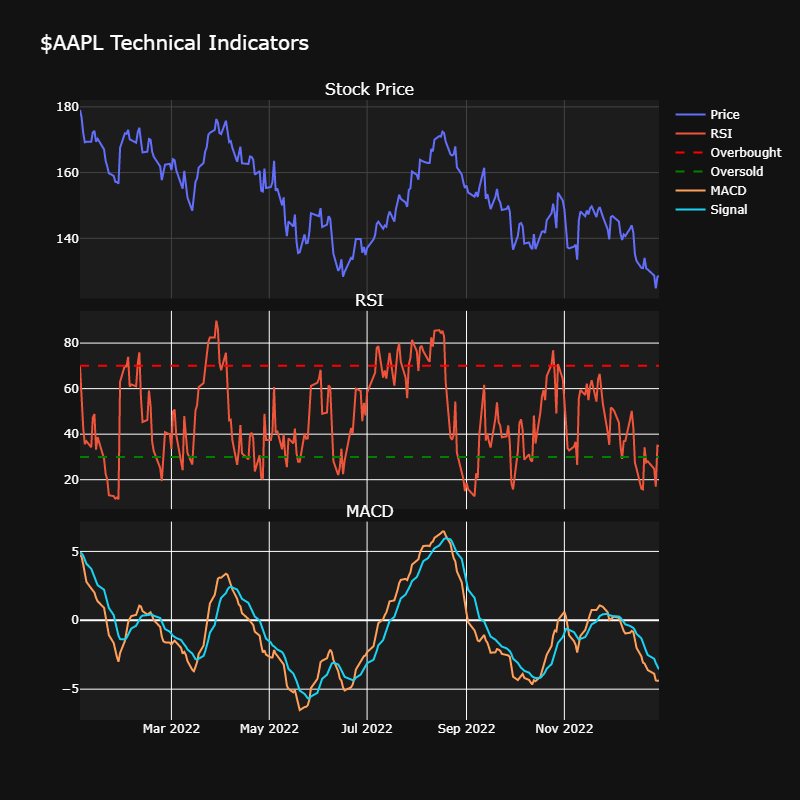

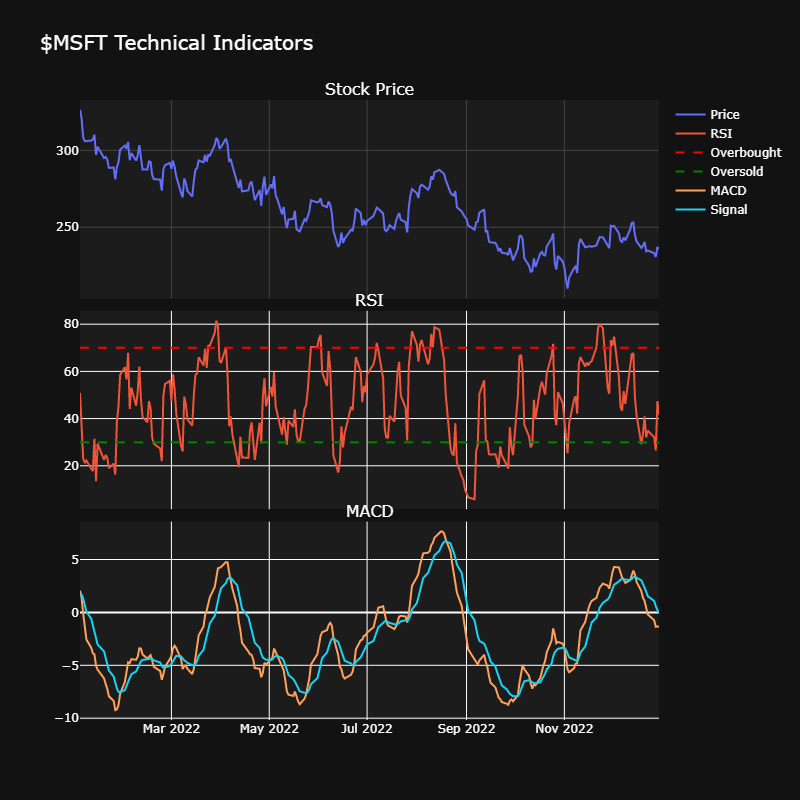

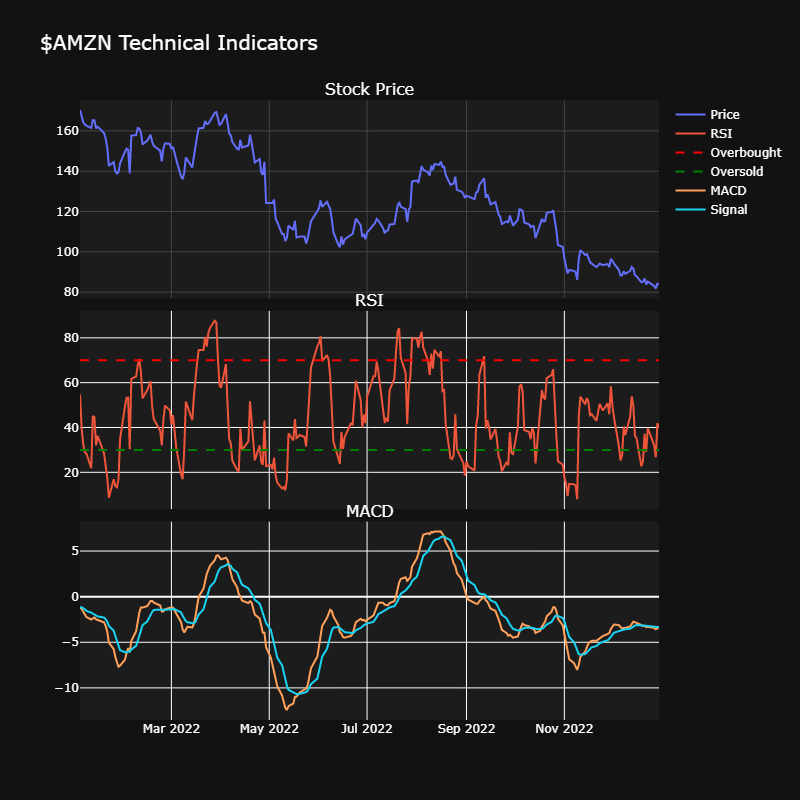

In [6]:
# take a view at what the technical indicator data looks like:
plot_technical_indicators(training_df, datetime.datetime(2022, 1, 1), datetime.datetime(2023, 1, 1), "aapl")
plot_technical_indicators(training_df, datetime.datetime(2022, 1, 1), datetime.datetime(2023, 1, 1), "msft")
plot_technical_indicators(training_df, datetime.datetime(2022, 1, 1), datetime.datetime(2023, 1, 1), "amzn")

### Preparing Congressional Trade Data for AAPL

C:\Users\abhin\AppData\Local\Temp\ipykernel_13164\1110066669.py:95: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



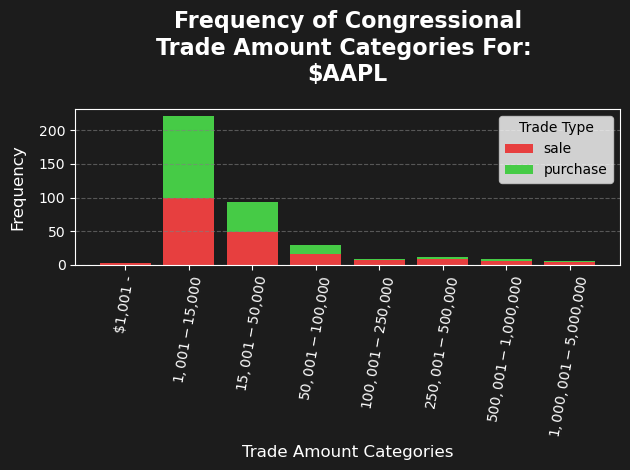

C:\Users\abhin\AppData\Local\Temp\ipykernel_13164\1110066669.py:95: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



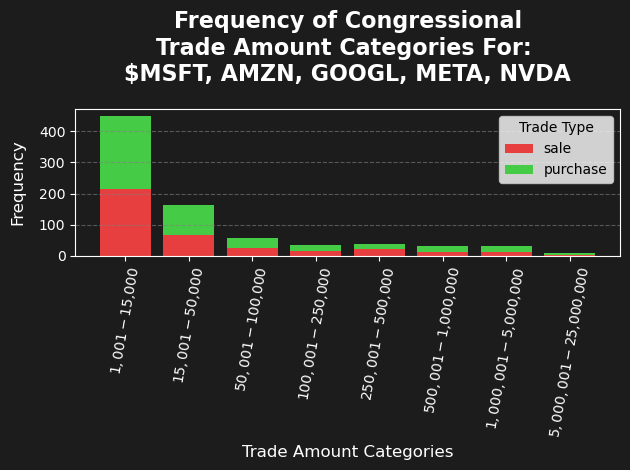

In [7]:
if "congressional_df" not in dir():
    congressional_df = pd.read_csv("./data/congressional_data.csv")

# understand how many relevant purchases and sales there are for each stock type
# we will be creating some sort of metric to quantify these congressional trading activities
plot_congressional_trades_bar(congressional_df, ["AAPL"])
plot_congressional_trades_bar(congressional_df, ["MSFT", "AMZN", "GOOGL", "META", "NVDA"])

In [8]:
training_congressional_df = extract_congressional_trades_ticker(congressional_df, ["AAPL"] + relevant_tickers)

training_congressional_df

,ticker,purchase,sale
disclosure_date,,,
2014-01-31,MSFT,1.0,0.0
2014-02-05,MSFT,1.0,0.0
2014-02-11,MSFT,1.0,0.0
2014-02-27,AAPL,0.0,1.0
2014-03-26,AAPL,0.0,1.0
...,...,...,...
2023-05-11,META,0.0,1.0
2023-05-11,MSFT,0.0,1.0
2023-05-11,NVDA,1.0,0.0


### Merging Tickers and Congressional Trading Data Together

In [9]:
is_aapl = (training_congressional_df["ticker"] == "AAPL")

aapl_congressional_df = training_congressional_df[is_aapl].copy()
aapl_congressional_df.columns = ["ticker", "purchase_aapl", "sale_aapl"]
aapl_congressional_df.drop("ticker", axis=1, inplace=True)
support_congressional_df = training_congressional_df[~is_aapl].copy()
support_congressional_df.columns = ["ticker", "purchase_support", "sale_support"]
support_congressional_df.drop("ticker", axis=1, inplace=True)

# there will be MANY NaN values in this dataframe because of the fact that there are a lot less
# congressional trades than there are stock data points. Imputation / feature engineering will be
# necessary down the line
training_ticker_congressional_df = pd.merge(
    training_df,
    aapl_congressional_df,
    left_index=True,
    right_index=True,
    how="left"
)

training_ticker_congressional_df = pd.merge(
    training_ticker_congressional_df,
    support_congressional_df,
    left_index=True,
    right_index=True,
    how="left"
)

# fill in all NaN values with zeros
training_ticker_congressional_df["purchase_aapl"].fillna(0, inplace=True)
training_ticker_congressional_df["sale_aapl"].fillna(0, inplace=True)
training_ticker_congressional_df["purchase_support"].fillna(0, inplace=True)
training_ticker_congressional_df["sale_support"].fillna(0, inplace=True)

# finally, get rid of unecessary columns. we denoted useful columns with the _ keyword
keep_cols = [c for c in training_ticker_congressional_df.columns if '_' in c] + ["AAPL:Adj Close"]


training_ticker_congressional_df = training_ticker_congressional_df[keep_cols[1:] + [keep_cols[0]]]

C:\Users\abhin\AppData\Local\Temp\ipykernel_13164\466978109.py:30: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



C:\Users\abhin\AppData\Local\Temp\ipykernel_13164\466978109.py:31: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=

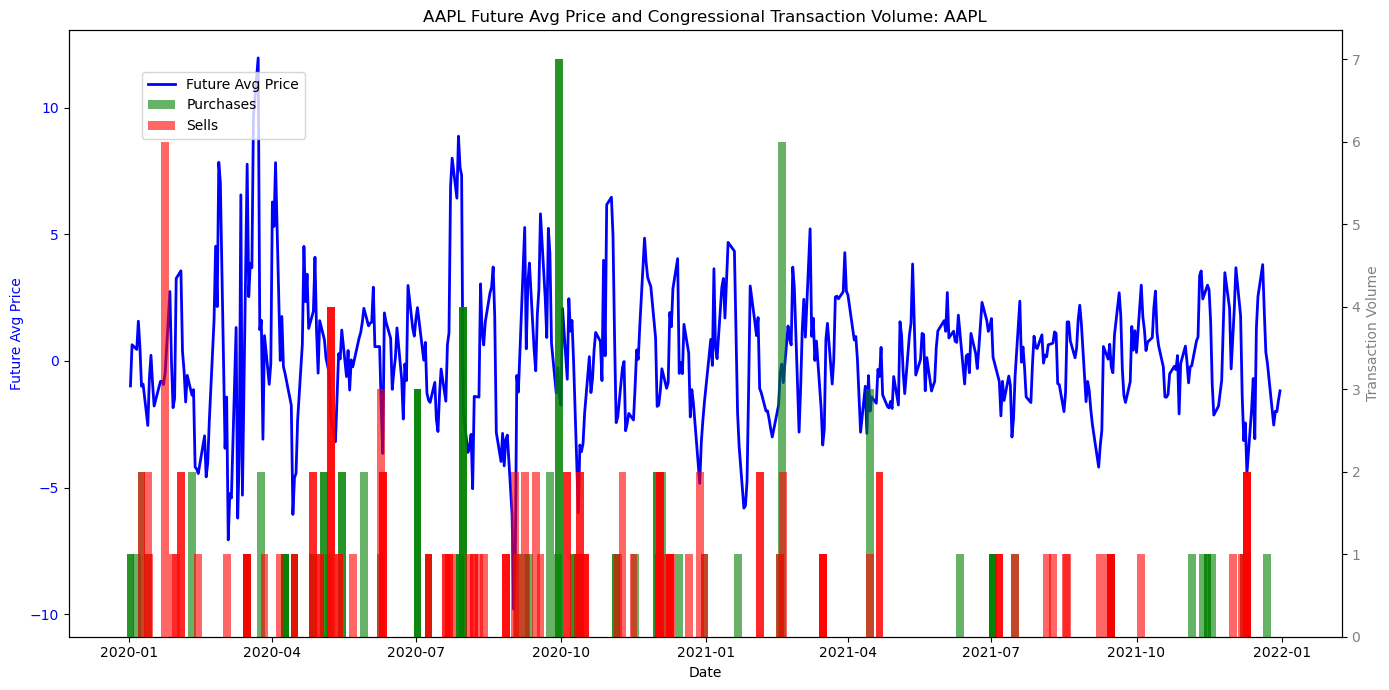

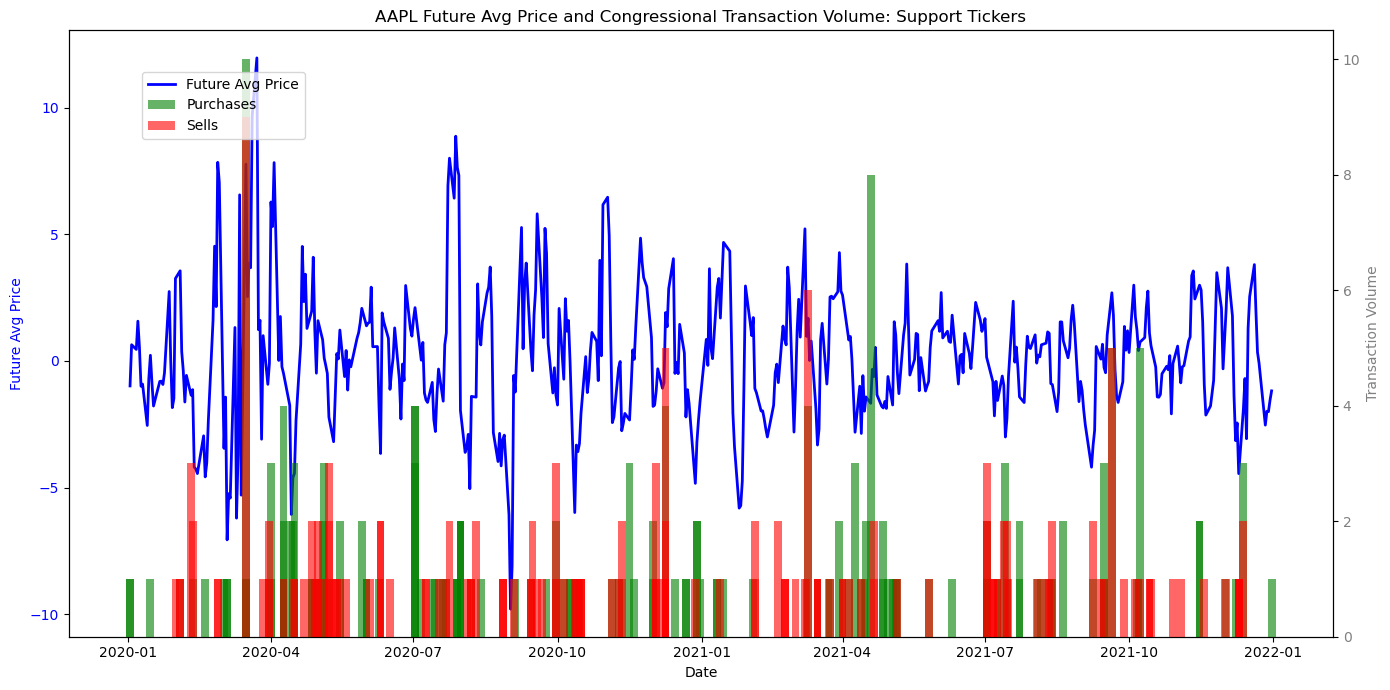

In [10]:
plot_congressional_trades_timeseries(
    training_ticker_congressional_df, start=datetime.datetime(2020, 1, 1), end=datetime.datetime(2022, 1, 1), ticker="aapl",
    barwidth=5, title="AAPL Future Avg Price and Congressional Transaction Volume: AAPL" 
)

plot_congressional_trades_timeseries(
    training_ticker_congressional_df, start=datetime.datetime(2020, 1, 1), end=datetime.datetime(2022, 1, 1), ticker="support",
    barwidth=5, title="AAPL Future Avg Price and Congressional Transaction Volume: Support Tickers"
)

<p>Further Data Cleaning</p>
As of now, we have all the raw data and partially handled some data cleaning. However, there are a few redundant features in this dataframe and other features that we no longer need, like the actual stock price, or the actual number for volumes. we can take the technical indicator data to determine actual stock price movement, and capture the relationship of the current volume of trading to the EWM of volumes. Also, for congressional data, we will compute a heuristic that is like a trading "signal" that decays over time so that the purchase and sale signals can span over more days and create a higher breadth of congressional trading data covereage for all days.

In [11]:
# useful for any sparse signal data, where you can smooth out the signal and maintain its relevance for
# a certain number of days after the signal is given
def exponential_decay_imputation(congressional_trade_volume: pd.Series, signal_decay: float = 0.9) -> pd.Series:
    
    # there is either a 10% decay or set the trade volume signal to the actual volume of trade
    signal_transformed = []

    for i in range(len(congressional_trade_volume)):
        if i == 0:
            signal_transformed.append(congressional_trade_volume[i])
            continue
        
        new_signal = max(signal_decay * signal_transformed[-1], congressional_trade_volume[i])
        signal_transformed.append(new_signal)

    return pd.Series(signal_transformed, index=congressional_trade_volume.index)

# capture the relationship between the MACD and signal line
def macd_signal_crossover(
        macd: pd.Series, signal: pd.Series, ticker: str, epsilon: int = 0.05, span: int = 30,
        signal_decay: float = 0.9) -> tuple[pd.Series, pd.Series, pd.Series]:
    # figure out when a crossover happens
    macd_diff = macd - signal

    # case where the difference is right on the line, consider that a crossover
    crossover = np.where(np.abs(macd_diff) <= epsilon, True, False)

    # sometimes the crossover jumps from negative to positive or vice versa
    macd_diff_shifted = macd_diff.shift(1, fill_value=0) # holds the previous value of the macd_diff on same location i 
    crossover = crossover | np.where(macd_diff * macd_diff_shifted < 0, True, False)

    # figure out the EWM of the macd line and compare it to the EWM of the signal line
    # if the macd line is above the signal line, that is a bullish crossover
    # if the macd line is below the signal line, that is a bearish crossover
    ewm_macd = macd.ewm(span=span, adjust=False).mean()
    ewm_signal = signal.ewm(span=span, adjust=False).mean()

    bullish_crossover = np.where(ewm_macd < ewm_signal, 1, 0)
    bullish_crossover = pd.Series(bullish_crossover)  # Convert to Series before applying ewm
    bullish_crossover = bullish_crossover & pd.Series(crossover)
    # apply an exponential weighted mean to smooth out the data
    # bullish_crossover = bullish_crossover.ewm(span=span, adjust=False).mean()

    bearish_crossover = np.where(ewm_macd >= ewm_signal, 1, 0)
    bearish_crossover = pd.Series(bearish_crossover)  # Convert to Series before applying ewm
    bearish_crossover = bearish_crossover & pd.Series(crossover)
    # apply an exponential weighted mean to smooth out the data
    # bearish_crossover = bearish_crossover.ewm(span=span, adjust=False).mean()


    # finally, apply some sort of signal smoothing (since a crossover is most relevant on the day it happens, sure.
    # however, it is also relevant in the days following the crossover up to a certain amount of time!)
    # bullish_crossover = bullish_crossover.ewm(span=span, adjust=False).mean()
    # bearish_crossover = bearish_crossover.ewm(span=span, adjust=False).mean()

    bullish_crossover = exponential_decay_imputation(bullish_crossover, signal_decay=signal_decay)
    bearish_crossover = exponential_decay_imputation(bearish_crossover, signal_decay=signal_decay)

    bullish_crossover.index = macd.index
    bearish_crossover.index = macd.index
    macd_diff.index = macd.index


    return bullish_crossover, bearish_crossover, macd_diff

# handle volume columns to capture the relative difference between the current volume and the EWM of the volume
def volume_ewm_proportion(volume: pd.Series, span: int = 30) -> pd.Series:
    ewm_volume = volume.ewm(span=span, adjust=False).mean()
    return volume / ewm_volume

<Axes: >

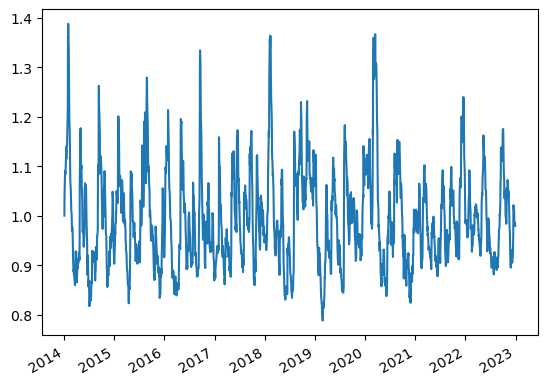

In [12]:
volume = volume_ewm_proportion(training_ticker_congressional_df["AAPL:Volume_ewm_long"], span=30)

volume.plot()

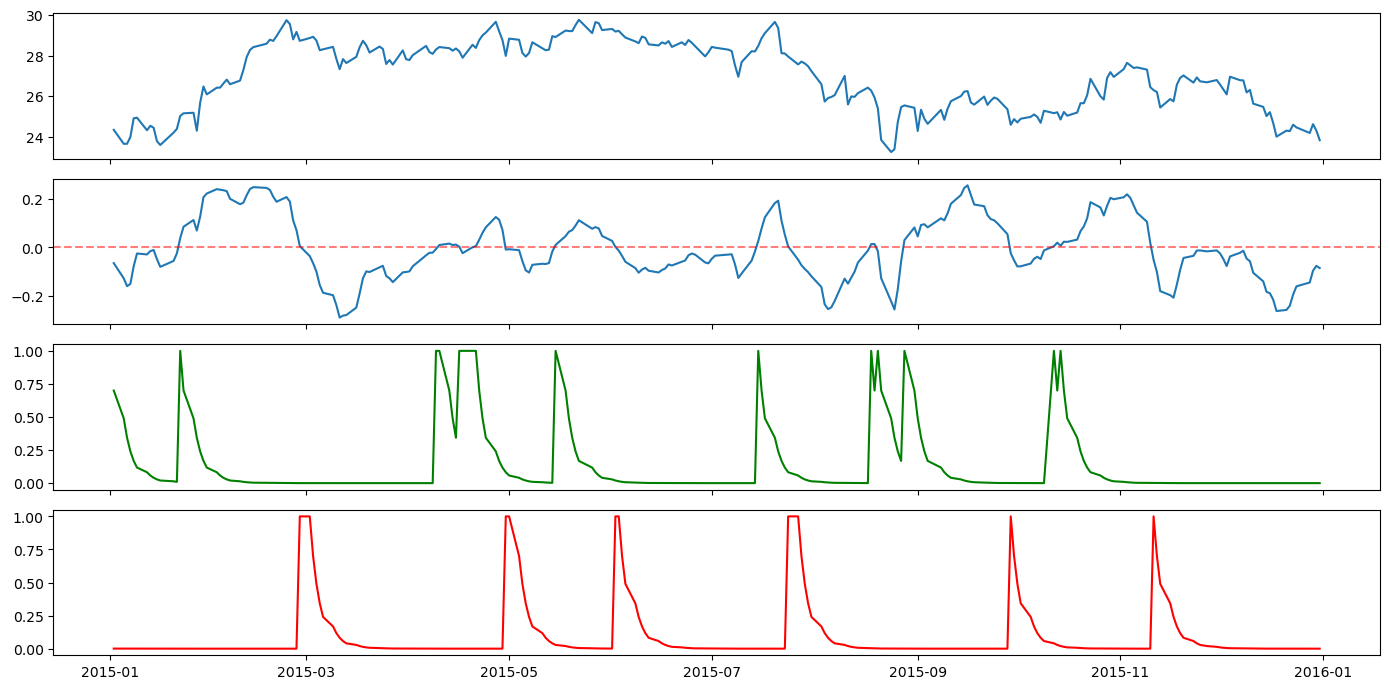

In [13]:
bullish, bearish, macd_diff = macd_signal_crossover(
    training_ticker_congressional_df["AAPL:Adj Close_macd"], training_ticker_congressional_df["AAPL:Adj Close_signal"], "AAPL",
    epsilon=0.01, span=10, signal_decay=0.7)

# plot the bullish and bearish crossover signals
fig, ax = plt.subplots(figsize=(14, 7), nrows=4, ncols=1, sharex=True)

start = datetime.datetime(2015, 1, 1)
end = datetime.datetime(2016, 1, 1)
iloc_series = (training_ticker_congressional_df.index >= start) & (training_ticker_congressional_df.index <= end)

ax[0].plot(training_ticker_congressional_df["AAPL:Adj Close"][iloc_series])
ax[1].plot(macd_diff[iloc_series])
ax[1].axhline(y=0, color="red", linestyle="--", alpha=0.5)
ax[2].plot(bullish[iloc_series], label="Bullish Crossover", color="green")
ax[3].plot(bearish[iloc_series], label="Bearish Crossover", color="red")

plt.tight_layout()
plt.show()

C:\Users\abhin\AppData\Local\Temp\ipykernel_13164\1248007932.py:10: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

C:\Users\abhin\AppData\Local\Temp\ipykernel_13164\1248007932.py:13: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



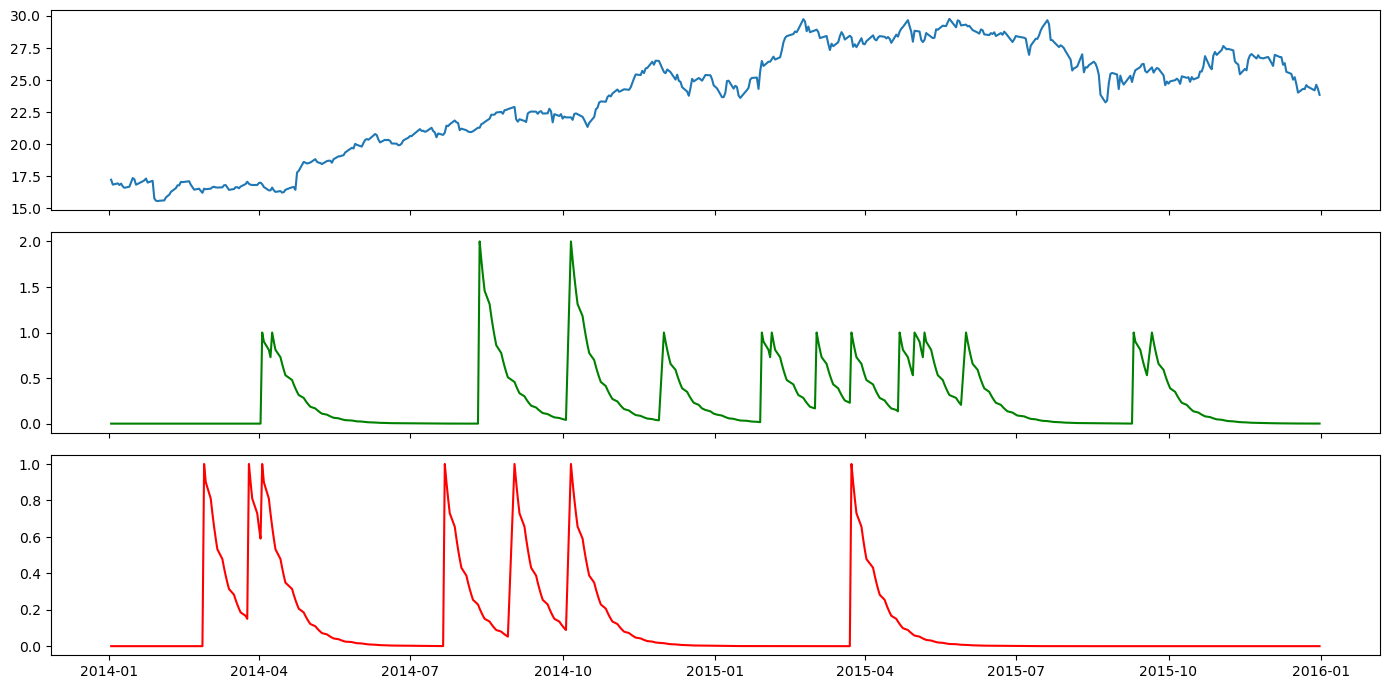

In [14]:
congressional_purchase = exponential_decay_imputation(training_ticker_congressional_df["purchase_aapl"])
congressional_sale = exponential_decay_imputation(training_ticker_congressional_df["sale_aapl"])

fig, ax = plt.subplots(figsize=(14, 7), nrows=3, ncols=1, sharex=True)

start = datetime.datetime(2010, 1, 1)
end = datetime.datetime(2016, 1, 1)
iloc_series = (training_ticker_congressional_df.index >= start) & (training_ticker_congressional_df.index <= end)

ax[0].plot(training_ticker_congressional_df["AAPL:Adj Close"][iloc_series])
ax[1].plot(congressional_purchase[iloc_series], label="Congressional Purchase", color="green")
ax[2].plot(congressional_sale[iloc_series], label="Congressional Sale", color="red")

plt.tight_layout()
plt.show()

Now that we see how these signals looks like and are related to the movement of stock prices, we can just apply these to every column of the dataframe!

In [15]:
training_df = pd.DataFrame(training_ticker_congressional_df["future_avg_price"])
all_colnames = training_ticker_congressional_df.columns
all_relevant_tickers = set([colname.split(':')[0] for colname in all_colnames if ':' in colname])

for ticker in all_relevant_tickers:
    # for each ticker, get the macd signals, RSI, and volume signals

    bullish, bearish, macd_diff = macd_signal_crossover(
        training_ticker_congressional_df[f"{ticker}:Adj Close_macd"], training_ticker_congressional_df[f"{ticker}:Adj Close_signal"], 
        ticker, epsilon=0.01, span=10, signal_decay=0.7)
    rsi = calculate_rsi(training_ticker_congressional_df[f"{ticker}:Adj Close_rsi"], period=14, use_exponential=True)
    volume = volume_ewm_proportion(training_ticker_congressional_df[f"{ticker}:Volume_ewm_long"], span=30)
    
    ticker = ticker.lower()

    training_df[f"{ticker}:macd_diff"] = macd_diff
    training_df[f"{ticker}:bullish"] = bullish
    training_df[f"{ticker}:bearish"] = bearish
    training_df[f"{ticker}:rsi"] = rsi / 100 # scaling RSI here itself

    if ticker == "^vix" or ticker == "dx-y.nyb":
        continue

    training_df[f"{ticker}:volume_prop"] = volume

# next, add the congressional purchase/ sale signals already there
training_df["purchase_aapl"] = exponential_decay_imputation(training_ticker_congressional_df["purchase_aapl"])
training_df["sale_aapl"] = exponential_decay_imputation(training_ticker_congressional_df["sale_aapl"])
training_df["purchase_support"] = exponential_decay_imputation(training_ticker_congressional_df["purchase_support"])
training_df["sale_support"] = exponential_decay_imputation(training_ticker_congressional_df["sale_support"])

# and our Y variable, the future average stock price for AAPL
training_df["future_avg_price"] = training_ticker_congressional_df["future_avg_price"]
training_df = training_df.dropna()

training_df

C:\Users\abhin\AppData\Local\Temp\ipykernel_13164\1248007932.py:10: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

C:\Users\abhin\AppData\Local\Temp\ipykernel_13164\1248007932.py:13: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

C:\Users\abhin\AppData\Local\Temp\ipykernel_13164\1248007932.py:10: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

C:\Users\abhin\AppData\Local\Temp\ipykernel_13164\1248007932.py:13: FutureWarning:

Series.__g

,future_avg_price,hg=f:macd_diff,hg=f:bullish,hg=f:bearish,hg=f:rsi,hg=f:volume_prop,aapl:macd_diff,aapl:bullish,aapl:bearish,aapl:rsi,...,cl=f:volume_prop,googl:macd_diff,googl:bullish,googl:bearish,googl:rsi,googl:volume_prop,purchase_aapl,sale_aapl,purchase_support,sale_support
2014-02-18,-3.327770,0.010245,0.0,0.0,0.872747,0.970039,0.103123,0.0,0.0,0.991024,...,0.989778,0.102560,0.0,0.0,0.803284,1.052719,0.0000,0.0000,0.656100,0.00000
2014-02-19,-1.529563,0.010563,0.0,0.0,0.917197,0.970209,0.085072,0.0,0.0,0.584551,...,0.960026,0.088852,0.0,0.0,0.556086,1.040137,0.0000,0.0000,0.590490,0.00000
2014-02-20,-0.176805,0.009666,0.0,True,0.826276,0.959850,0.058566,0.0,0.0,0.472069,...,0.953912,0.075956,0.0,0.0,0.462477,1.018663,0.0000,0.0000,0.531441,0.00000
2014-02-21,1.115208,0.009411,0.0,True,0.834227,0.941861,0.028427,0.0,0.0,0.406681,...,0.943256,0.060873,0.0,0.0,0.665332,1.004002,0.0000,0.0000,0.478297,0.00000
2014-02-24,0.780883,0.010188,0.0,0.7,0.851580,0.943844,0.012503,0.0,0.0,0.408692,...,0.935214,0.058311,0.0,0.0,0.700967,0.986299,0.0000,0.0000,0.430467,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-10,-0.008906,0.032504,0.000046,0.057648,0.589927,0.718974,-0.393757,0.000559,0.082354,0.606078,...,1.031851,-0.093732,0.000016,0.009689,0.725304,1.140224,2.0000,1.0000,2.700000,5.40000
2022-11-11,-2.275332,0.043227,0.000032,0.040354,0.796368,0.712035,0.218472,True,0.057648,0.610328,...,1.031912,0.451173,True,0.006782,0.746659,1.120302,1.8000,0.9000,2.430000,4.86000
2022-11-14,-1.741290,0.041178,0.000023,0.028248,0.512642,0.745289,0.513364,0.7,0.040354,0.586978,...,1.034750,0.751615,0.7,0.004748,0.789369,1.097581,1.6200,0.8100,2.187000,4.37400
2022-11-15,-2.972880,0.036275,0.000016,0.019773,0.469452,0.751625,0.793555,0.49,0.028248,0.676940,...,1.040500,1.100998,0.49,0.003323,0.875840,1.097452,1.4580,0.7290,1.968300,3.93660


### Data Exploration: Understanding Correlations and Clustering Tendency of Our Stock Market Data

Finally, we have a dataset we can work with. For this section we are doing data exploration again but this time it is exploring the clustering and relationships of one variable with another.

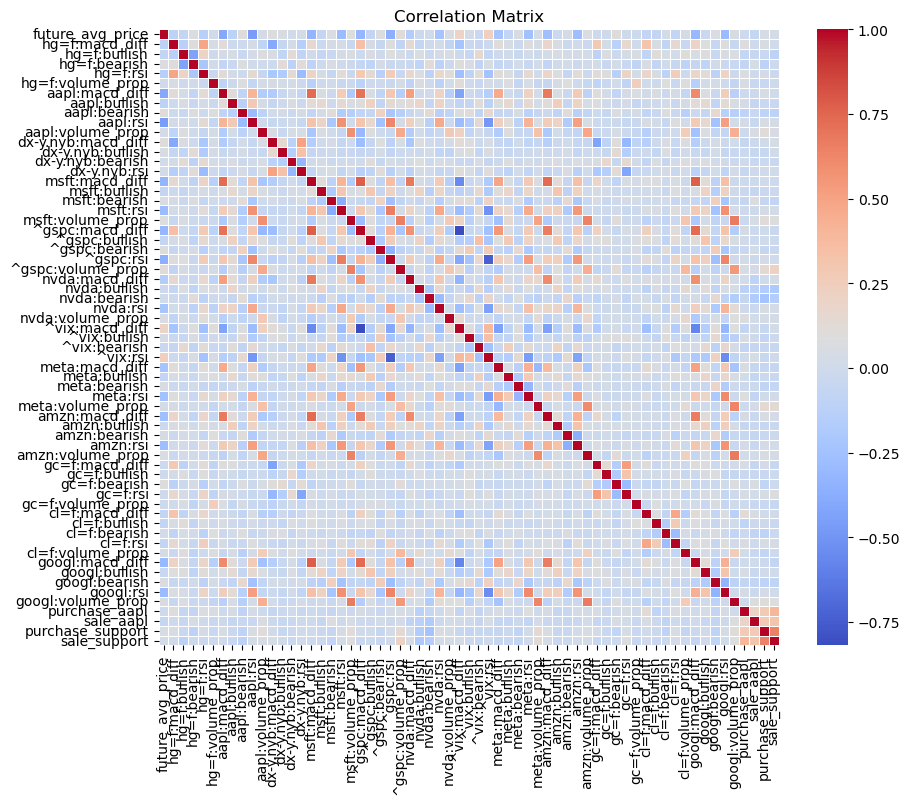

In [16]:
import seaborn as sns

def plot_correlation_matrix(training_df: pd.DataFrame) -> None:
    X = training_df

    correlation_matrix = X.corr()
    # Set up the matplotlib figure
    plt.figure(figsize=(10, 8))

    # Create a heatmap to visualize the correlation matrix
    sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt='.2f', linewidths=0.5,
                xticklabels=correlation_matrix.columns, yticklabels=correlation_matrix.columns)

    # Set the title of the heatmap
    plt.title('Correlation Matrix')

    # Show the plot
    plt.show()

plot_correlation_matrix(training_df)

Given this correlation matrix, we definitely have a high relationship of variables for metrics such as the MACD and RSI variables. However, for data such as congressional trading signals and the MACD bullish/ bearish signals, they are not significantly correlated with other continuous variables. This is fine for our purposes because that is expected of the signal data due to their sparse/ rare nature. One thing to note is that models such as decision trees or neural nets are pretty versatile and can handle sparse data well, so for the purposes of this project we will keep those values in.

we can still use this matrix to prune out other indicator data that do not have significant relationships with anything else in the dataset. this can be done by visually selecting out the variables that we dont need anymore.

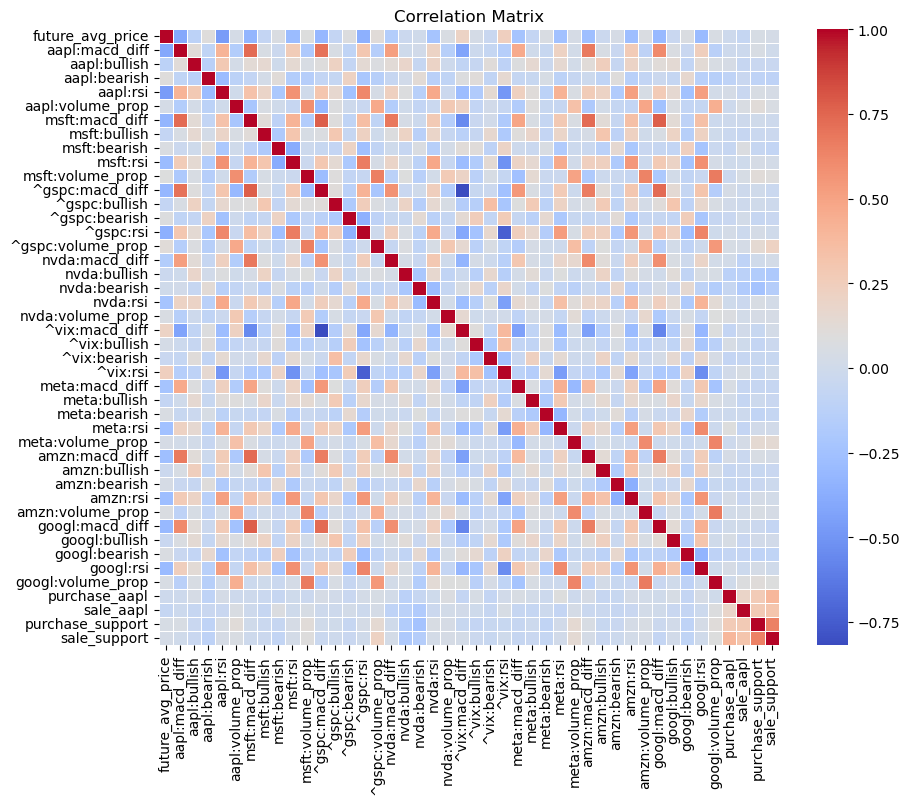

In [17]:
# visually looking at this matrix, we can remove out cl=f, hg=f, & gc=f since they dont seem to correlate well with anything anyways

remove = set([
    "cl=f", "hg=f", "gc=f", "dx-y.nyb"
])

def contains_remove(colname: str) -> bool:
    for rem in remove:
        if rem in colname:
            return True
    return False

cols_to_keep = [colname for colname in training_df.columns if not contains_remove(colname)]

# a slightly cleaner correlation matrix, and these are all the symbols that we will be using for our model
plot_correlation_matrix(training_df[cols_to_keep])

In [18]:
# so given that we now know the relevant columns, we can finalize our training dataframe to have these relevant features
training_df = training_df[cols_to_keep]
training_df

,future_avg_price,aapl:macd_diff,aapl:bullish,aapl:bearish,aapl:rsi,aapl:volume_prop,msft:macd_diff,msft:bullish,msft:bearish,msft:rsi,...,amzn:volume_prop,googl:macd_diff,googl:bullish,googl:bearish,googl:rsi,googl:volume_prop,purchase_aapl,sale_aapl,purchase_support,sale_support
2014-02-18,-3.327770,0.103123,0.0,0.0,0.991024,1.049218,0.079817,0.0,0.0,0.649580,...,1.254730,0.102560,0.0,0.0,0.803284,1.052719,0.0000,0.0000,0.656100,0.00000
2014-02-19,-1.529563,0.085072,0.0,0.0,0.584551,1.038197,0.080189,0.0,0.0,0.655976,...,1.230481,0.088852,0.0,0.0,0.556086,1.040137,0.0000,0.0000,0.590490,0.00000
2014-02-20,-0.176805,0.058566,0.0,0.0,0.472069,1.027059,0.086425,0.0,0.0,0.640070,...,1.197690,0.075956,0.0,0.0,0.462477,1.018663,0.0000,0.0000,0.531441,0.00000
2014-02-21,1.115208,0.028427,0.0,0.0,0.406681,1.012476,0.095288,0.0,0.0,0.912434,...,1.180608,0.060873,0.0,0.0,0.665332,1.004002,0.0000,0.0000,0.478297,0.00000
2014-02-24,0.780883,0.012503,0.0,0.0,0.408692,1.001467,0.079302,0.0,0.0,0.575531,...,1.156051,0.058311,0.0,0.0,0.700967,0.986299,0.0000,0.0000,0.430467,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-10,-0.008906,-0.393757,0.000559,0.082354,0.606078,1.040096,1.057652,0.343,0.028248,0.700325,...,1.250201,-0.093732,0.000016,0.009689,0.725304,1.140224,2.0000,1.0000,2.700000,5.40000
2022-11-11,-2.275332,0.218472,True,0.057648,0.610328,1.036757,2.098861,0.2401,0.019773,0.706722,...,1.244214,0.451173,True,0.006782,0.746659,1.120302,1.8000,0.9000,2.430000,4.86000
2022-11-14,-1.741290,0.513364,0.7,0.040354,0.586978,1.020158,2.328023,0.16807,0.013841,0.634155,...,1.228450,0.751615,0.7,0.004748,0.789369,1.097581,1.6200,0.8100,2.187000,4.37400
2022-11-15,-2.972880,0.793555,0.49,0.028248,0.676940,1.016433,2.405300,0.117649,0.009689,0.678948,...,1.222785,1.100998,0.49,0.003323,0.875840,1.097452,1.4580,0.7290,1.968300,3.93660


One more piece of data exploration that is worth looking into is the clustering tendency of all the data we already have. 

In [19]:

import matplotlib.pyplot as plt

def plot_pca_dataset(training_df: pd.DataFrame, threshold: float = 0.2):
    # Separate features (X) and target variable (y)
    X = training_df.drop("future_avg_price", axis=1)
    y_below = training_df["future_avg_price"] <= -threshold
    y_above = training_df["future_avg_price"] > threshold
    y_middle = ~y_below & ~y_above
    y = training_df["future_avg_price"] > threshold

    # Scale the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Perform PCA
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)

    # Explained variance for each component
    explained_variance = pca.explained_variance_ratio_

    # Total explained variance
    total_variance = explained_variance.sum()

    # Colors based on the target (future average price threshold)
    colors = ['red' if label else 'blue' for label in y]

    # Plot the PCA components
    plt.figure(figsize=(10, 8))
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=colors, alpha=0.6)

    # Set the title with explained variance
    plt.title(f"PCA of Training Data\n"
            f"Total Explained Variance: {total_variance:.2f} "
            f"(PC1: {explained_variance[0]:.2f}, PC2: {explained_variance[1]:.2f})")

    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.grid(True)

    # Show the plot
    plt.show()

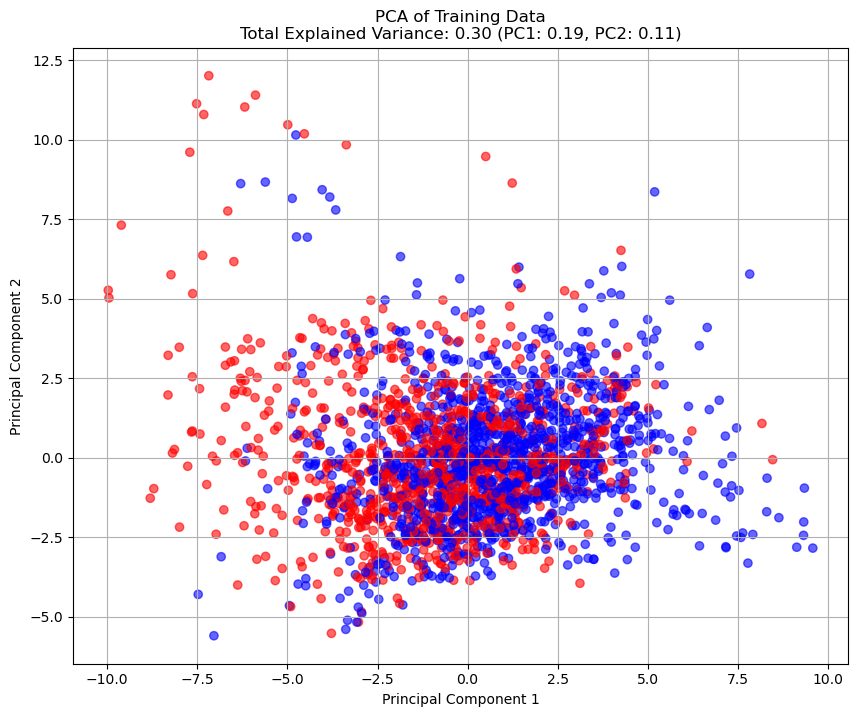

In [20]:
plot_pca_dataset(training_df)

There isn't an obvious clustering between good or bad stocks in this analysis. This is expected because after all, we are dealing with the stock market here. It is difficult to predict the stock market, and this PCA definitely reflects that issue well. Given this PCA plot, we don't expect our model to be perfect, but we still hope to see the model being able to predict the general trend/ direction of stock price movements given all the data provided to it.

### Modeling

We will try two models: Random Forests and Neural Networks.

The first part of this notebook explores regression via a Random Forest Regressor and a regressor Neural Network. The results from this revealed to us that trying to employ regression on stock market data is very difficult.

Then, we pivot our approach to classification...

 For actual model training, because we are using time series data, we have to modify our cross validation pipeline to not just pick random samples, but basically train on data that it has seen before and then predict future prices. this is important for the prevention of data leakage.

In [21]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, RandomForestRegressor
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import GridSearchCV

In [22]:
# X and y, both sharing the same timeseries index
X = training_df.drop("future_avg_price", axis=1)
y = training_df["future_avg_price"]

### Training a Random Forest Regressor

important points here is that you need to do a time series for cross validation because you need to ensure that past data is used to predict future. otherwise, there will be sources of data leakage which is not good!


We can try using either regression or classification and see what works best

In [ ]:
# the classifier
rf_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("rf", RandomForestRegressor(random_state=42))
])

rf_param_grid = {
    'rf__n_estimators': [20, 50, 100, 200],
    'rf__max_depth': [None, 10, 20, 30],
    'rf__min_samples_split': [2, 5, 10],
    'rf__min_samples_leaf': [1, 2, 4, 8, 16],
    'rf__max_features': ['sqrt', 'log2']
}

rf_time_split_inner = TimeSeriesSplit(n_splits=5)

rf_inner_grid_search = GridSearchCV(
    estimator=rf_pipeline,
    param_grid=rf_param_grid,
    cv=rf_time_split_inner,
    scoring="neg_mean_absolute_error",
    n_jobs=-1,
    verbose=2
)

rf_time_split_outer = TimeSeriesSplit(n_splits=5)

mse_scores, r2_scores, explained_var_scores = [], [], []

fig, ax = plt.subplots(figsize=(10, 15), nrows=5, ncols=1)
i = 0

for train_index, test_index in rf_time_split_outer.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    rf_inner_grid_search.fit(X_train, y_train)

    best_pipeline = rf_inner_grid_search.best_estimator_

    y_pred = best_pipeline.predict(X_test)
    y_pred = pd.Series(y_pred, index=y_test.index)

    # accuracy
    mse = mean_squared_error(y_test, y_pred)
    mse_scores.append(mse)

    # precision
    r2 = r2_score(y_test, y_pred)
    r2_scores.append(r2)

    # recall
    explained_var = explained_variance_score(y_test, y_pred)
    explained_var_scores.append(explained_var)

    ax[i].set_title(f"Time Series Split {i + 1}")
    ax[i].plot(y_test, label="Actual")
    ax[i].plot(y_pred, label="Predicted")
    ax[i].set_xlabel("Date")
    ax[i].set_ylabel("Price Change %")
    ax[i].axhline(0, color="red", linestyle="--", alpha=0.5)

    i += 1

plt.legend()
plt.tight_layout()
plt.show()

Fitting 5 folds for each of 480 candidates, totalling 2400 fits
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


c:\Users\abhin\miniconda3\envs\mlproject\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning:

invalid value encountered in cast



Fitting 5 folds for each of 480 candidates, totalling 2400 fits


In [ ]:
# so how did we do?
print("Summary Statistics of Random Forest Regression:")
print(f"Mean Squared Error: {np.mean(mse_scores)}")
print(f"R2 Score: {np.mean(r2_scores)}")
print(f"Explained Variance Score: {np.mean(explained_var_scores)}")

print(f"Best Parameters: {rf_inner_grid_search.best_params_}")

After looking at these results, it is pretty clear that the model does not do the greatest job at perfectly predicting the stock price. This is expected. It is incredibly hard to put a number on the future movement of a stock price, especially if crucial features of technical indicators are not present like congressional trading purchase signals or MACD line crossing.

Despite not performing well for regression (~0.17 R2 score), it is still notable how the overall direction / trend of stock price movements seem to be reflected in our model

### Training a Neural Network Regressor

A Neural Network is comparable to a random forest classifier because it excels at capturing complex, non-linear patterns. In addition, these sorts of models also handle larger amounts of features better than if you were to use a random forest classifier, which might suffer from the curse of dimensionality for features.



In [ ]:
# in a very similar way as the random forest regressor, we can create a neural network
# regressor on time series cross validation data.
from sklearn.neural_network import MLPRegressor


nn_pipeline = Pipeline([
    ("scaler", StandardScaler()),  # Scaling the features
    ("nn", MLPRegressor(random_state=42))  # Neural Network Regressor
])

# Hyperparameter grid for MLPRegressor
nn_param_grid = {
    'nn__hidden_layer_sizes': [
        (20,),
        (50,),
        (70,),
        (20, 10), 
        (50, 10), 
        (70, 10),
        (20, 20),
        (50, 20),
        (70, 20)],
    'nn__activation': ['relu'],
    'nn__solver': ['adam', 'sgd'],
    'nn__learning_rate': ['constant', "invscaling"],
    'nn__max_iter': [200, 400, 800]
}

# TimeSeries cross-validation for inner loop grid search
nn_time_split_inner = TimeSeriesSplit(n_splits=5)

# GridSearchCV for tuning the MLP regressor hyperparameters
nn_inner_grid_search = GridSearchCV(
    estimator=nn_pipeline,
    param_grid=nn_param_grid,
    cv=nn_time_split_inner,
    scoring="neg_mean_absolute_error",
    n_jobs=-1,
    verbose=2
)

# TimeSeries cross-validation for outer loop to evaluate performance
nn_time_split_outer = TimeSeriesSplit(n_splits=5)

mse_scores, r2_scores, explained_var_scores = [], [], []

# Create subplots for visualization
fig, ax = plt.subplots(figsize=(10, 15), nrows=5, ncols=1)
i = 0

# Outer loop: time series cross-validation for model evaluation
for train_index, test_index in nn_time_split_outer.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Fit the grid search on the training data
    nn_inner_grid_search.fit(X_train, y_train)

    # Get the best pipeline from grid search
    best_pipeline = nn_inner_grid_search.best_estimator_

    # Predict using the best model
    y_pred = best_pipeline.predict(X_test)
    y_pred = pd.Series(y_pred, index=y_test.index)

    # Calculate and store evaluation metrics
    mse = mean_squared_error(y_test, y_pred)
    mse_scores.append(mse)

    r2 = r2_score(y_test, y_pred)
    r2_scores.append(r2)

    explained_var = explained_variance_score(y_test, y_pred)
    explained_var_scores.append(explained_var)

    # Plot actual vs predicted for each fold
    ax[i].set_title(f"Time Series Split {i + 1}")
    ax[i].plot(y_test, label="Actual")
    ax[i].plot(y_pred, label="Predicted")
    ax[i].set_xlabel("Date")
    ax[i].set_ylabel("Price Change %")
    ax[i].axhline(0, color="red", linestyle="--", alpha=0.5)

    i += 1

# Adjust layout and show the plots
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
print("Summary Statistics of Neural Network Regression:")
print(f"Mean Squared Error: {np.mean(mse_scores)}")
print(f"R2 Score: {np.mean(r2_scores)}")
print(f"Explained Variance Score: {np.mean(explained_var_scores)}")

print(f"Best Parameters: {nn_inner_grid_search.best_params_}")

Using neural networks seemed to bring us significantly worse results. (explain why)

Overall, using regression for stock price prediction is challenging. The very low R2 values reflect that even if the stock price prediction is in the right direction, the actual distance between actual and predicted stock price values is still too different. 

However, we realized that even if regression for Random Forests and Neural networks is not able to predict actual price values of stocks, they do tend to get the direction of price correct some of the time.

We can try to take advantage of this propery of stock price predictions and attempt to build a classification model. So let us try that next!

### Training a Random Forest Classifier

First, transform the numerical Y values into something that a classifier can handle

In [ ]:
from sklearn.preprocessing import OneHotEncoder

thresh = 0.8

y_categorical_buy = y > thresh
y_categorical_neutral = (y <= thresh) & (y >= -thresh)
y_categorical_sell = y < -thresh

# y can represent multiple classes, but we can use an integer to
# represent each class. For example, 0 for sell, 1 for neutral, and 2 for buy

# this is because scikit learn classifiers require integer labels
""" 
    sell = 0
    neutral = 1
    buy = 2
"""
y_categorical = y_categorical_sell.astype(int) + y_categorical_neutral.astype(int) * 2 + y_categorical_buy.astype(int) * 3

# take a look at what these value distributions look like
y_categorical.value_counts()

there are a lot more sell signals than there are buy or neutral signals. how do we handle this data imbalance?

there is a class_weight parameter in the RandomForestClassifier object, and this will assign a varying penalization factor based on the frequencies of classes.

In [ ]:
rf_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("rf", RandomForestClassifier(random_state=42, class_weight="balanced", n_jobs=-1))
])

# share the same rf_param_grid as before, but I am explicitly setting it
# here as well for clarity
rf_param_grid = {
    'rf__n_estimators': [100],
    'rf__max_depth': [None, 10, 20, 30],
    'rf__min_samples_split': [2, 5, 10],
    'rf__min_samples_leaf': [4],
    'rf__max_features': ['sqrt', 'log2']
}

# Define TimeSeriesSplit for inner cross-validation
rf_time_split_inner = TimeSeriesSplit(n_splits=5)

# GridSearchCV for parameter tuning with time series split
rf_inner_grid_search = GridSearchCV(
    estimator=rf_pipeline,
    param_grid=rf_param_grid,
    cv=rf_time_split_inner,
    scoring="accuracy",  # Use classification score (e.g., accuracy)
    n_jobs=-1,
    verbose=2
)

# Define TimeSeriesSplit for outer cross-validation
rf_time_split_outer = TimeSeriesSplit(n_splits=3)

# Store metrics for evaluation
accuracy_scores = []
precision_scores = []
recall_scores = []

y_actuals = []
y_preds = []

# Outer loop for time series cross-validation
for train_index, test_index in rf_time_split_outer.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    # y changed to y_categorical here!!!
    y_train, y_test = y_categorical.iloc[train_index], y_categorical.iloc[test_index]

    # Fit the inner grid search to find the best parameters
    rf_inner_grid_search.fit(X_train, y_train)

    # Get the best pipeline from the grid search
    best_pipeline = rf_inner_grid_search.best_estimator_

    # Predict on the test set
    y_pred = best_pipeline.predict(X_test)
    y_pred = pd.Series(y_pred, index=y_test.index)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_scores.append(accuracy)

    # Calculate precision
    precision = precision_score(y_test, y_pred, average='weighted')
    precision_scores.append(precision)

    # Calculate recall
    recall = recall_score(y_test, y_pred, average='weighted')
    recall_scores.append(recall)

    y_actuals.append(y_test)
    y_preds.append(y_pred)

In [ ]:
accuracy_scores

In [ ]:
for i in range(len(y_actuals)):
    print(confusion_matrix(y_actuals[i], y_preds[i]))

In [ ]:
# also talk about precision/ recall scores

These are some very impressive results for accuracy scores for stock predictions. However, in this case, we need to know how many of each category our model is getting right. It is easy to just predict "sell" for everything and be right most of the time, but we want to make sure that the "buy" is specifically high in accuracy as well as the "sell". If you are in "neutral", then assume that the stock price prediction is not able to confidently be predicted.

In [ ]:
def evaluate_predictions(model_name, y_true, y_pred):
    global evaluation_results
    
    # Print confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    print(f"Model: {model_name}")
    print("Confusion Matrix:")
    print(cm)

    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

    # Print metrics
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    # Append metrics to the DataFrame
    evaluation_results = pd.concat(
        [
            evaluation_results,
            pd.DataFrame({
                "Model": [model_name],
                "Accuracy": [accuracy],
                "Precision": [precision],
                "Recall": [recall],
                "F1 Score": [f1]
            })
        ],
        ignore_index=True
    )

In [ ]:
do the same process as above, but now with adaboosting, then with a neural network classifier. and then try on an SVM

talk about accuracy scores, precision, recall, and confusion matrices for each thing and explain what that means

In [ ]:
after everything, have some table comparing all models regressors and classifications
done with modeling